# F: Medición de la relación señal-ruido (`SNR`) en una estrella

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import os

from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import ICRS, Galactic, FK4, FK5

from astropy.io import fits
from astropy.visualization import make_lupton_rgb

## Buscando en un directorio y abriendo el último archivo 

In [2]:
directorio = 'imagenes/tarantula/*'
lista_archivos = glob.glob(directorio) # * means all if need specific format then *.csv
ultimo_archivo = max(lista_archivos, key=os.path.getctime)

imagen = fits.open(ultimo_archivo)
header = imagen[0].header
data = imagen[0].data

## Graficando el campo

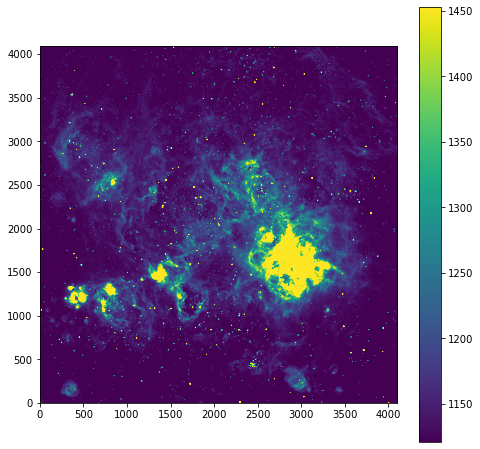

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow(data, vmin=np.min(data)*1.1, vmax=np.mean(data)/0.8,origin='lower')

plt.colorbar()
plt.show()

## Ingresando las coordenadas donde esta la estrella que busco

In [4]:
ra = '85.2283818'   
dec = '-69.1753229'

## Localizando las estrellas con `skycoord` y `wcs` de `astropy`

In [5]:
coordenadas_estrella = SkyCoord(ra, dec, unit=u.deg, frame = ICRS)
w = WCS(header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## Buscando la posición de las coordenadas en mi imagen

In [6]:
x_0, y_0 = w.world_to_pixel(coordenadas_estrella)
x_0 = int(x_0)
y_0 = int(y_0)

## Localizando la estrella en la imagen

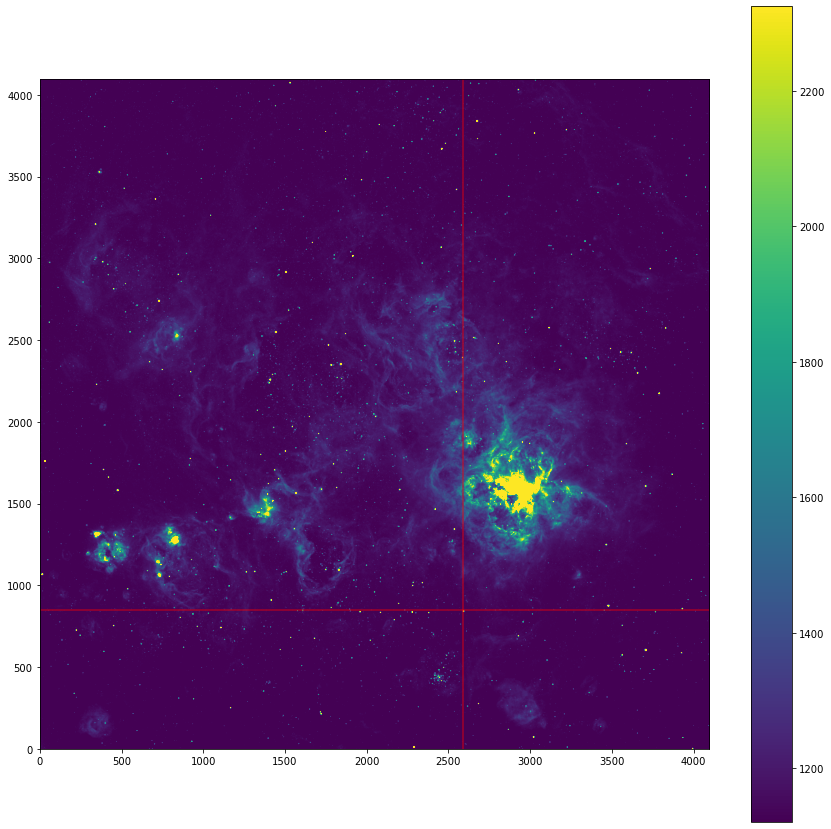

In [7]:
plt.figure(figsize=(15, 15))
#plt.imshow(r_data[y-npix_estrella:y+npix_estrella, x-npix_estrella:x+npix_estrella], vmin=np.min(r_data)*1.1, vmax=np.mean(r_data)/0.8,origin='lower')
plt.imshow(data, vmin=np.min(data)*1.1, vmax=np.mean(data)/0.5,origin='lower')

plt.axhline(y=int(y_0), color='r', linestyle='-', alpha= 0.5)
plt.axvline(x=int(x_0), color='r', linestyle='-', alpha=0.5)
#plt.imshow(region, vmin=np.min(r_data)*1.1, vmax=np.mean(r_data)/0.8,origin='lower')
plt.colorbar()
plt.show()

## Tomando una región centrada en la estrella

In [8]:
ancho = int(200/2) # tomo un cuadrado de 100*100 pixeles, procuraremos que sea par
region = data[y_0-int(ancho/2):y_0+int(ancho/2), x_0-int(ancho/2):x_0+int(ancho/2)] # cogo los datos que encuentran en esa region

In [9]:
x_1 = np.where(region == region.max())[1][0] # elijo el punto mas brillante de la region, hay que tener quidado con los hot pixeles 
y_1 = np.where(region == region.max())[0][0] 

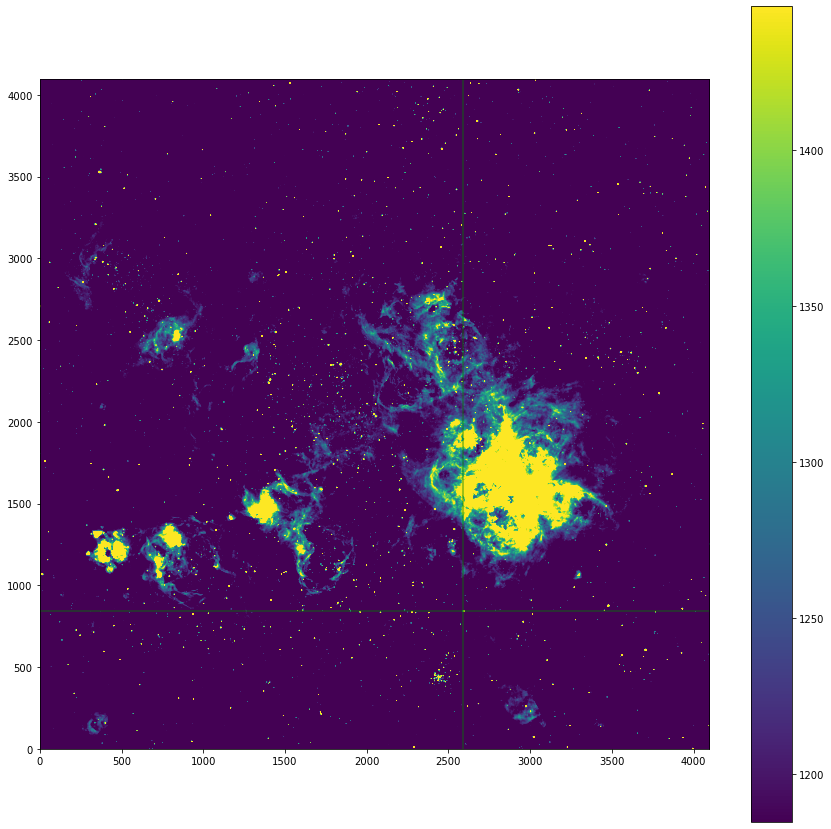

In [10]:
if x_0 < x_1:
    x = x_0 + abs((x_1-int(len(region)/2))) # paso de la region pequeña a la imagen grande para tener referencias
else: 
    x = x_0 - abs((x_1-int(len(region)/2)))
if y_0 > y_1:
    y = y_0 - abs((y_1-int(len(region)/2)))
else:
    y = y_0 + abs((y_1-int(len(region)/2)))

plt.figure(figsize=(15, 15))
plt.imshow(data, vmin=np.min(region)*1.1, vmax=np.mean(region)/0.8, origin='lower')

plt.axhline(y=y, color='g', linestyle='-', alpha= 0.5)
plt.axvline(x=x, color='g', linestyle='-', alpha= 0.5)

#plt.axhline(y=int(len(region)/2), color='r', linestyle='-', alpha= 0.5)
#plt.axvline(x=int(len(region)/2), color='r', linestyle='-', alpha=0.5)
plt.colorbar()
plt.show()

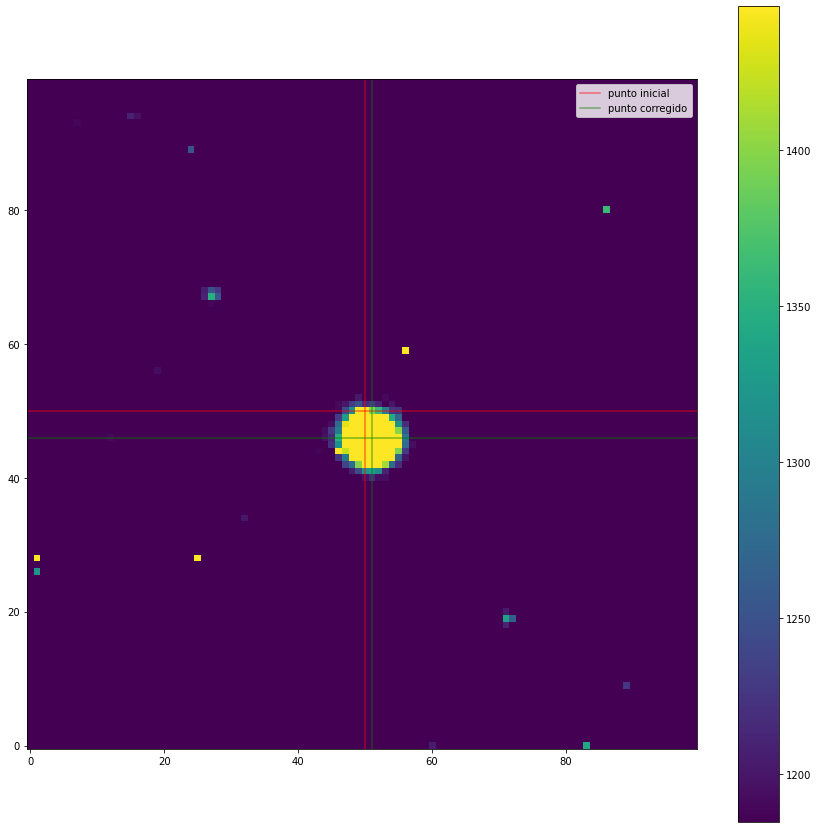

In [11]:
plt.figure(figsize=(15, 15))
plt.imshow(region, vmin=np.min(region)*1.1, vmax=np.mean(region)/0.8, origin='lower')

plt.axhline(y=int(len(region)/2), color='r', linestyle='-', alpha= 0.5, label= 'punto inicial')
plt.axvline(x=int(len(region)/2), color='r', linestyle='-', alpha=0.5)

plt.axhline(y=y_1, color='g', linestyle='-', alpha= 0.5, label = 'punto corregido')
plt.axvline(x=x_1, color='g', linestyle='-', alpha= 0.5)

plt.colorbar()
plt.legend()
plt.show()

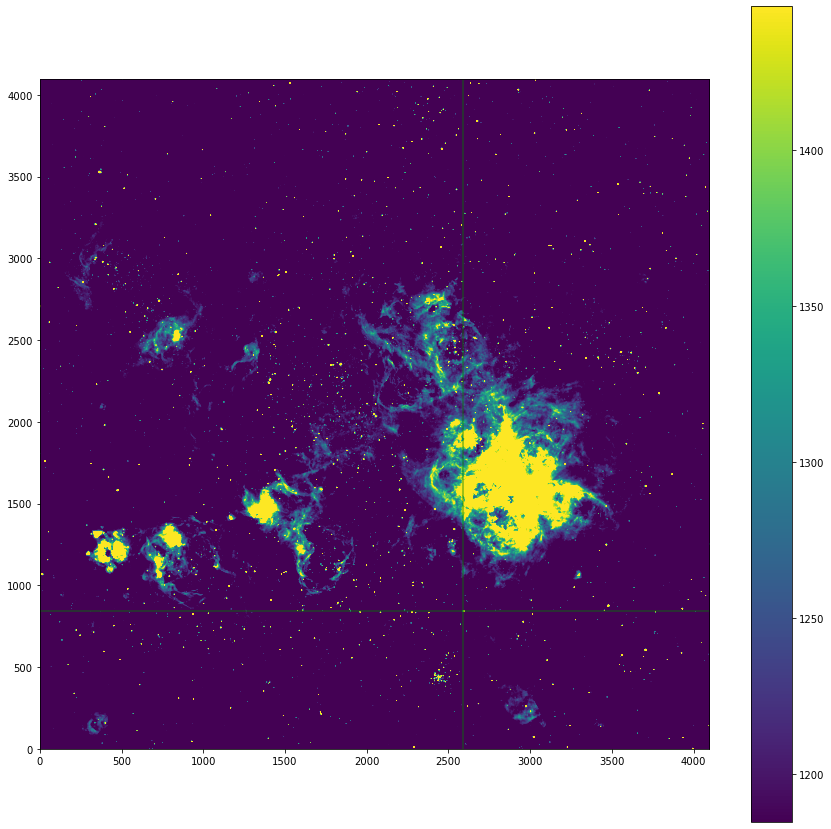

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(data, vmin=np.min(region)*1.1, vmax=np.mean(region)/0.8, origin='lower')

plt.axhline(y=y, color='g', linestyle='-', alpha= 0.5)
plt.axvline(x=x, color='g', linestyle='-', alpha= 0.5)

#plt.axhline(y=int(len(region)/2), color='r', linestyle='-', alpha= 0.5)
#plt.axvline(x=int(len(region)/2), color='r', linestyle='-', alpha=0.5)
plt.colorbar()
plt.show()

## Midiendo la `SNR`

In [13]:
# la señal la defino como la media de los valores de los pixeles en un subframe pequeño para que abarque parte de la estrella
npix_estrella = int(10/2) # tendre (10/2)^2 pixeles, un cuadrado de 5x5

señal = np.mean(data[y-npix_estrella:y+npix_estrella, x-npix_estrella:x+npix_estrella])  

In [14]:
# El ruido lo puedo medir en toda la imagen quitando las estrellas brillantes o en un subframe cerca de la estrella a medir

# El ruido lo tomare como la media de los pixeles quitando las estrellas + la desviacion estandar
media_ruido = sigma_clipped_stats(data[y-ancho:y+ancho,x-ancho: x+ancho], sigma=3, maxiters=5)[0]
std_ruido = sigma_clipped_stats(data[y-ancho:y+ancho,x-ancho: x+ancho], sigma=3, maxiters=5)[2]

ruido_region = media_ruido + std_ruido 

In [15]:
# por ultimo calculo la relacion señal/ruido de la estrella

In [16]:
SNR_puntual = señal/ruido_region # aqui no llega a ser puntual porque estamos cogiendo unos cuantos pixeles pero muy pocos
SNR_map = data/ruido_region # aqui todos los que sean mayores que 1 se puede considerar que sobrepasan el nivel de ruido
SNR_puntual

3.560699778261226

## Visualizando los datos obtenidos

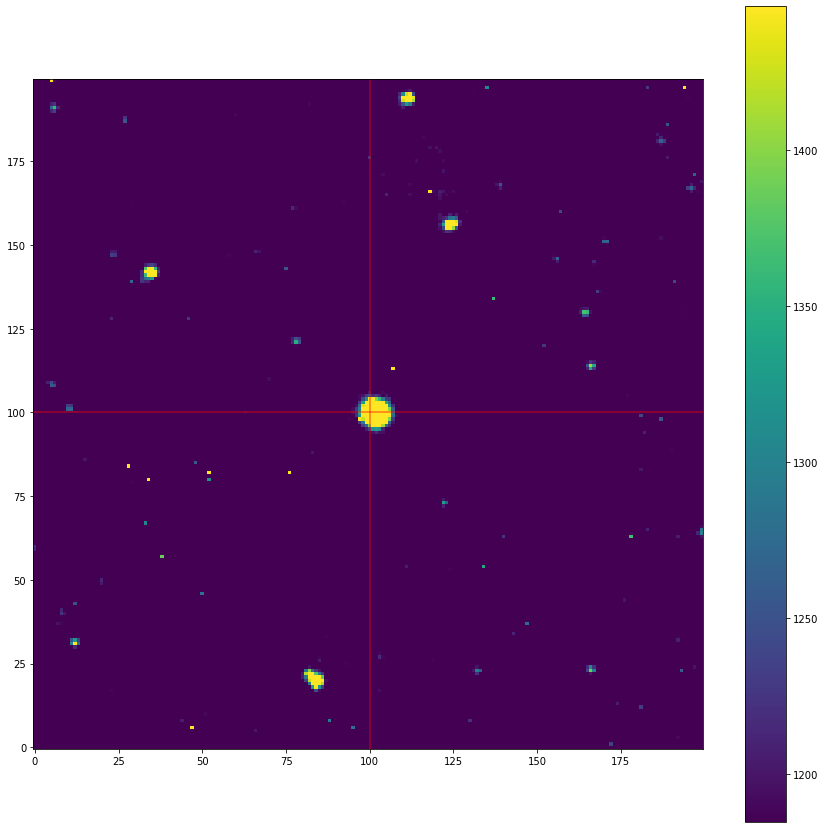

In [17]:
plt.figure(figsize=(15, 15))
plt.imshow(data[y-ancho:y+ancho, x-ancho:x+ancho], vmin=np.min(region)*1.1, vmax=np.mean(region)/0.8, origin='lower')

plt.axhline(y=int(len(region)), color='r', linestyle='-', alpha= 0.5)
plt.axvline(x=int(len(region)), color='r', linestyle='-', alpha=0.5)

plt.colorbar()
plt.show()

In [18]:
# voy a definir un array para realizar un analisis de los datos donde hemos medido la señal
flujo_señal_x = data[y,x-ancho: x+ancho] 
flujo_señal_y = data[y-ancho: y+ancho,x] 

In [19]:
len(flujo_señal_x)

200

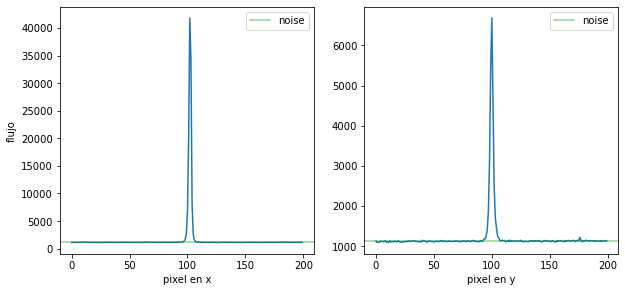

In [20]:
fig=plt.figure(figsize=(10,10))

ax_1=fig.add_subplot(221)

inicio_x = len(data)
final_x = len(data)
ax_1.plot(np.arange(0,len(flujo_señal_x)), flujo_señal_x)

ax_1.axhline(y=ruido_region, color='g', linestyle='-', label='noise', alpha=0.4)
ax_1.legend(loc="upper right")
ax_1.set_xlabel('pixel en x')
ax_1.set_ylabel('flujo')
#ax_1.set_ylim([0, 7000])

ax_2=fig.add_subplot(222)
ax_2.plot(np.arange(0,len(flujo_señal_y)), flujo_señal_y)
ax_2.axhline(y=ruido_region, color='g', linestyle='-', label='noise', alpha=0.4)
ax_2.legend(loc="upper right")
ax_2.set_xlabel('pixel en y')
#ax_2.set_ylim([0, 7000])

plt.show()

In [21]:
SNR_puntual

3.560699778261226